 # Who Really Survived *The Titanic*?
 ## by Payton Frens and Jacob Tocila







## Overview

We set out to find out who really survived the sinking of *The Titanic*. Popular culture states that women and children were prioritized during evacuation, but were there other factors at play? Were *"all women and children"* really prioritized, or were the rich more likely to survive?

Our dataset ([linked here](https://www.kaggle.com/datasets/yasserh/titanic-dataset)) is about the passengers of *The Titanic*. The Titanic disaster is well-documented and there are many datasets about it, including one from [Standford University](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv). Our dataset includes the name of each passenger, sex, age, passenger class, ticket number, price of ticket, and whether they survived (1 = survived, 0 = did not survive). It also includes two tables of people each passenger was traveling with: one for any siblings/spouses and another for parents/children (a 0 in both columns indicates the passenger was traveling alone).

## Prior Work

There have been many other people using the dataset to predict who survived *The Titanic*. Here is one.

### [Titanic Survival Classification](https://www.kaggle.com/code/virajgowari/titanic-survival-classification) by user VIRAJ GOWARI

This work took each of the numeric columns and found the mean, standard deviation, minimum, maximum, first quartile, third quartile, and median for each value. The use of PassengerID seems a little odd since each passenger has a unique ID. The user also factored in the missing values for "Age" when training the data, which makes their accuracy score reliable.

## Approach

**Specific Question:** Who was most likely to survive *The Titanic*? If women and children were really prioritized, then the survived category should consist of mostly those in the "female" category and any male who is 21 and under (since the voting age was 21 at the time of the ship's sinking). For it to be truly *all* women and children, a passenger's class cannot affect their likelihood of survival. We will know if passenger class wasn't a factor in survivalhood if the rate of people who survived is the same for each class (for example: 1st class survivors/ total 1st class passengers is roughly the same for 2nd class survivors/ total 2nd class passengers AND 3rd class survivors/ total 3rd class passengers).

We will do this by implementing a Decision Tree model and refine it with Random Forest. We will also use OneHotEncoding for the categorical features and feature engineering to improve accuracy.

The Titanic disaster is well-documented. Our particular dataset most likely originated from [Standford University](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv), but we downloaded it from Kaggle since it already sorted the columns neatly. The data itself is most likely post-1985 (when the shipwreck was discovered). Information about all the passengers is most likely from business records of the ship's company and the actual survivors' testimonies.

**Data:** There are 891 total rows for each survivor of The Titanic (although there were reportedly 2,208 passengers). Each row reports the PassengerID (which acts as an index for each row), if the passenger survived (0=did not survive, 1=survived), the class of the passenger (1st, 2nd, or 3rd), the passenger's name, the passenger's sex, the passenger's age, if the passenger was traveling with siblings/spouses, if the passenger was traveling with any parents/children, the passenger's ticket, and how much their ticket cost. In the 1st row is Mr. Owen Harris Braund who was a 22 year-old male in 3rd class. Mr. Braund's ticket was "A/5 21171" and he spent 7.25 on his fare (roughly $240 when adjusted for inflation). He was traveling with only his brother since the Sibling/Spouse column has a 1 and a Mr. Lewis Richard Braund in 3rd class was also traveling with only 1 person in the Sibling/Spouse column. Unfortunately, Mr. Owen Harris Braund did not survive the sinking.

**Features:** There are 9 features in our dataset. Our categorical features include Survived (if the passenger survived), Pclass (the passenger's class on the ship), Name, Sex, and Ticket. Our numerical features include Age, SibSp (Siblings/Spouses traveling with the passenger), Parch (Parents/Children traveling with the passenger), and Fare. There is also a PassengerID, but as stated previously, that is more like an index for the different rows.

**Appropriateness:** The data is very useful for our approach. It includes a lot of important information about the passengers. A few drawbacks are that this dataset only includes 891 people, which may not be completely representative of the 2,208 people who were onboard The Titanic. The dataset also does not specify if the person was a crewmember (if they were included), which might be useful. Although the Sibling/Spouse and Parents/Children columns are reasonably understandable, it would be helpful to have an additional column reporting the names of the people each passenger was traveling with.

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

## Exploratory Data Analysis (EDA)

* Show plots or tables illustrating the distribution of at least two variables in your dataset. Comment on anything interesting you observe.
* Show plots illustrating bivariate relationships for at least 2 pairs of variables. Comment on anything interesting you observe (e.g., strength of relationship, dependence on other factors).
* Summarize your EDA findings: how do your observations inform the modeling?


In [ ]:
titanic_df = pd.read_csv('Titanic-Dataset.csv')
# print(titanic_df.head(), "\n")
# print(titanic_df.count()) # Ranges from 204 (not all passengers have a cabin) to 891 (all passengers have a PassengerId)

# First task is to clean the data and remove any rows with missing values.
# Remove rows with missing values except for 'Cabin' since many passengers don't have cabin info.
# titanic_df = titanic_df.dropna(subset=['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']) # List everything except 'Cabin'

print(titanic_df.count(), "\n") # 712 rows with complete data (excluding 'Cabin')

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64 



In [ ]:
# Distribution of 'Sex'
sex_distribution = titanic_df['Sex'].value_counts()
print(sex_distribution, "\n")

# Distribution of 'Survived'
survived_distribution = titanic_df['Survived'].value_counts()
print(survived_distribution, "\n")

class_distribution = titanic_df['Pclass'].value_counts()
print(class_distribution, "\n")

# Distribution of 'Age' (we chose 21 because that was the age of majority at the time)
# titanic_df['Age Group'] = np.where(titanic_df['Age'] < 21, 'Child', 'Adult')

# Multiple Age Groups - Historically appropriate for 1912
# Age ranges reflect 1912 life stages:
# - Children under 12 (prepubescent)
# - Youth 12-20 (working age began around 12-14, age of majority was 21)
# - Young Adults 21-35 (prime working/childbearing years)
# - Middle Age 36-55 (life expectancy was ~50-55 in 1912)
# - Elderly 56+ (well beyond average life expectancy)

titanic_df['Age Group'] = pd.cut(
    titanic_df['Age'],
    bins=[0, 12, 21, 35, 55, 100],
    labels=['Child (0-11)', 'Youth (12-20)', 'Young Adult (21-35)', 'Middle Age (36-55)', 'Elderly (56+)']
)

age_distribution = titanic_df['Age Group'].value_counts()
print(age_distribution, "\n")

# A 2d array plot of sex and Survived (text-based)
survival_by_sex = titanic_df.groupby(['Sex', 'Survived'])['Survived'].value_counts().unstack(fill_value=0)
print(survival_by_sex, "\n")

Sex
male      577
female    314
Name: count, dtype: int64 

Survived
0    549
1    342
Name: count, dtype: int64 

Pclass
3    491
1    216
2    184
Name: count, dtype: int64 

Age Group
Young Adult (21-35)    293
Middle Age (36-55)     177
Youth (12-20)          135
Child (0-11)            69
Elderly (56+)           40
Name: count, dtype: int64 

Survived    0    1
Sex               
female     81  233
male      468  109 



In [ ]:
# Replace 0 with 'Died' and 1 with 'Survived' for better readability
titanic_df['Survived'] = titanic_df['Survived'].replace({0: 'Died', 1: 'Survived'})

# Bivariate plotly graphs for distributions
fig = px.histogram(titanic_df, x='Sex', color='Survived', barmode='group', title='Survival by Sex')
fig.show()

fig = px.histogram(titanic_df, x='Pclass', color='Survived', barmode='group', title='Survival by Passenger Class')
fig.show()

fig = px.histogram(titanic_df, x='Age Group', color='Survived', barmode='group', title='Survival by Passenger Age')
fig.show()

### Observations:

Chart 1 - Survival by Sex:
Far more men died than survived (the large blue bar shows about 470 deaths).
More women survived than died (the large red bar shows about 230 survivors).
Women had a much higher survival rate than men.
The "women and children first" policy is clearly visible in this data.

Chart 2 - Survival by Passenger Class:
Third class (3) had the most deaths by far (about 370 people died).
First class (1) passengers had the best survival rate - more survived than died.
Second class (2) was fairly balanced between deaths and survivors.
Your ticket class strongly affected your chances of survival.
Wealthier passengers in first class were much more likely to survive than those in third class.

Key takeaway: Both your sex and your passenger class were major factors in whether you survived the Titanic disaster. Being female and being in first class gave you the best odds of survival.


## Modeling

In [ ]:
titanic_modeling_df = pd.read_csv('Titanic-Dataset.csv') # Survived is our target variable here

y = titanic_modeling_df['Survived'] # 0 = died, 1 = survived

# Feature selection - choosing meaningful features for prediction
# We'll use: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
# Dropping: PassengerId (just an index), Name (too unique), Ticket (too unique), Cabin (too much missing data)
X = titanic_modeling_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

### Why are we using these features?
We're looking for "Survived" as our target variable
- Class and Sex --> "women and children first" policy
- Age to identify children
- Family size (SibSp + Parch) may affect survival
- Fare correlates with class and cabin location
- Embarked may correlate with cabin location on ship

In [ ]:
# Identify categorical and numerical columns
categorical_features = ['Sex', 'Embarked']
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Create preprocessing pipeline and handle missing values and encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

### Why are we using a preprocessor?

- Numerical features: fill missing values with median
- Categorical features: fill missing values with most frequent, then one-hot encode

In [ ]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"Training survival rate: {y_train.mean():.2%}")
print(f"Test survival rate: {y_test.mean():.2%}")

# Training set size: 712 samples
# Test set size: 179 samples
# Training survival rate: 38.34%
# Test survival rate: 38.55%

# Nice.


Training set size: 712 samples
Test set size: 179 samples
Training survival rate: 38.34%
Test survival rate: 38.55%


Now that we have a preprocessor... let's make a model. We decided to go with a decision tree since it's an easy way to visualize how the model flows to make it's decision.

Other perks of using a decision tree for this project:
- Easy to interpret and visualize data
- Can capture non-linear relationships (ex: children vs adults)
- Handles both categorical and numerical data

In [ ]:
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5))
])

# Note that if a tree is to tall, we could see overfitting. We are using a height of 5

# Train the model
dt_model.fit(X_train, y_train)

# Cross-validation (5-fold)
cv_scores_dt = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy (5-fold): {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std():.4f})", "\n")

# Predictions on test set
y_pred_dt = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)

print(f"Test Set Accuracy: {dt_accuracy:.4f}", "\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=['Died', 'Survived']))

# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:")
print(f"                 Predicted Died  Predicted Survived")
print(f"Actually Died         {cm_dt[0,0]:3d}              {cm_dt[0,1]:3d}")
print(f"Actually Survived     {cm_dt[1,0]:3d}              {cm_dt[1,1]:3d}")


Cross-Validation Accuracy (5-fold): 0.8189 (+/- 0.0243) 

Test Set Accuracy: 0.7654 

Classification Report:
              precision    recall  f1-score   support

        Died       0.77      0.88      0.82       110
    Survived       0.75      0.58      0.66        69

    accuracy                           0.77       179
   macro avg       0.76      0.73      0.74       179
weighted avg       0.76      0.77      0.76       179

Confusion Matrix:
                 Predicted Died  Predicted Survived
Actually Died          97               13
Actually Survived      29               40


### What are we looking at here?

```
# Cross-Validation Accuracy (5-fold): 0.8189 (+/- 0.0243)

# Test Set Accuracy: 0.7654

# Classification Report:
#               precision    recall  f1-score   support

#         Died       0.77      0.88      0.82       110
#     Survived       0.75      0.58      0.66        69

#     accuracy                           0.77       179
#    macro avg       0.76      0.73      0.74       179
# weighted avg       0.76      0.77      0.76       179

# Confusion Matrix:
#                  Predicted Died  Predicted Survived
# Actually Died          97               13
# Actually Survived      29               40
```

A confusion matrix compares what actually happened versus what the model predicted.

Interpretation:

- cm[0,0] = 97
People who actually died and the model predicted died.
This is a true positive for the "died" class.

- cm[0,1] = 13
People who actually died but the model predicted survived.
This is a false negative. These are misses.

- cm[1,0] = 29
People who actually survived but the model predicted died.
This is a false positive. These are over-predictions.

- cm[1,1] = 40
People who actually survived and the model predicted survived.
This is a true negative.

Summary: this model isn't very accurate and we need to do improvements. We can do either a Random Forest, AdaBoost, or Feature Engineering

In [ ]:
# A histogram visually showing how well our initial model works showing predicted survived vs died compared to actual survived vs died

df_plot = pd.DataFrame({
    "Category": ["Actual Died", "Actual Survived", "Predicted Died", "Predicted Survived"],
    "Count": [
        np.sum(y_test == 0),
        np.sum(y_test == 1),
        np.sum(y_pred_dt == 0),
        np.sum(y_pred_dt == 1)
    ],
    "Type": ["Actual", "Actual", "Predicted", "Predicted"]
})

fig = px.bar(
    df_plot,
    x="Category",
    y="Count",
    color="Type",
    color_discrete_map={"Actual": "maroon", "Predicted": "gold"},
    text="Count",
    title="Initial Decision Tree model: Actual vs Predicted Survival Outcomes"
)

fig.update_traces(textposition="outside")
fig.update_layout(template="plotly_white", xaxis_title="Category", yaxis_title="Count")
fig.show()

## Modeling (improvement)

We decided that using a random forest model would be great here because our dataset used mixed feature types (numerical and categorical), has nonlinear relationships, and our model is currently underfitting in some cases.

In [ ]:
# Create Random Forest pipeline
random_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10,
                                         random_state=42, min_samples_split=5))
])



Hyperparameters:
- n_estimators = 100: Use 100 trees in the forest
- max_depth = 10: Maximum tree depth
- min_samples_split = 5: Minimum samples required to split a node

In [ ]:
random_forest_model.fit(X_train, y_train) # Train the model

# Cross-validation
cv_scores_rf = cross_val_score(random_forest_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy (5-fold): {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

# Predictions on test set
y_pred_rf = random_forest_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"\nTest Set Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, y_pred_rf, target_names=['Died', 'Survived']))


Cross-Validation Accuracy (5-fold): 0.8189 (+/- 0.0239)

Test Set Accuracy: 0.8101
              precision    recall  f1-score   support

        Died       0.81      0.91      0.85       110
    Survived       0.82      0.65      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



Our previous test set accuracy was 0.7654.

Now our test set accuracy is 0.8101 which is an increase of about 5%. Not bad


In [ ]:
# Histogram for the improved Random Forest model: actual vs predicted survival

df_plot_rf = pd.DataFrame({
    "Category": ["Actual Died", "Actual Survived", "Predicted Died", "Predicted Survived"],
    "Count": [
        np.sum(y_test == 0),
        np.sum(y_test == 1),
        np.sum(y_pred_rf == 0),
        np.sum(y_pred_rf == 1)
    ],
    "Type": ["Actual", "Actual", "Predicted", "Predicted"]
})

fig = px.bar(
    df_plot_rf,
    x="Category",
    y="Count",
    color="Type",
    color_discrete_map={"Actual": "maroon", "Predicted": "gold"},
    text="Count",
    title="Random Forest: Actual vs Predicted Survival Outcomes"
)

fig.update_traces(textposition="outside")
fig.update_layout(template="plotly_white", xaxis_title="Category", yaxis_title="Count")
fig.show()


As seen by our visualization, our model *is* more accurate than our initial model. Though it's by such a small margin that we only improved by being more accurate on just 2 people. (Predicted died: 126 --> 124, actual: 110)

## Partial Dependency Plot


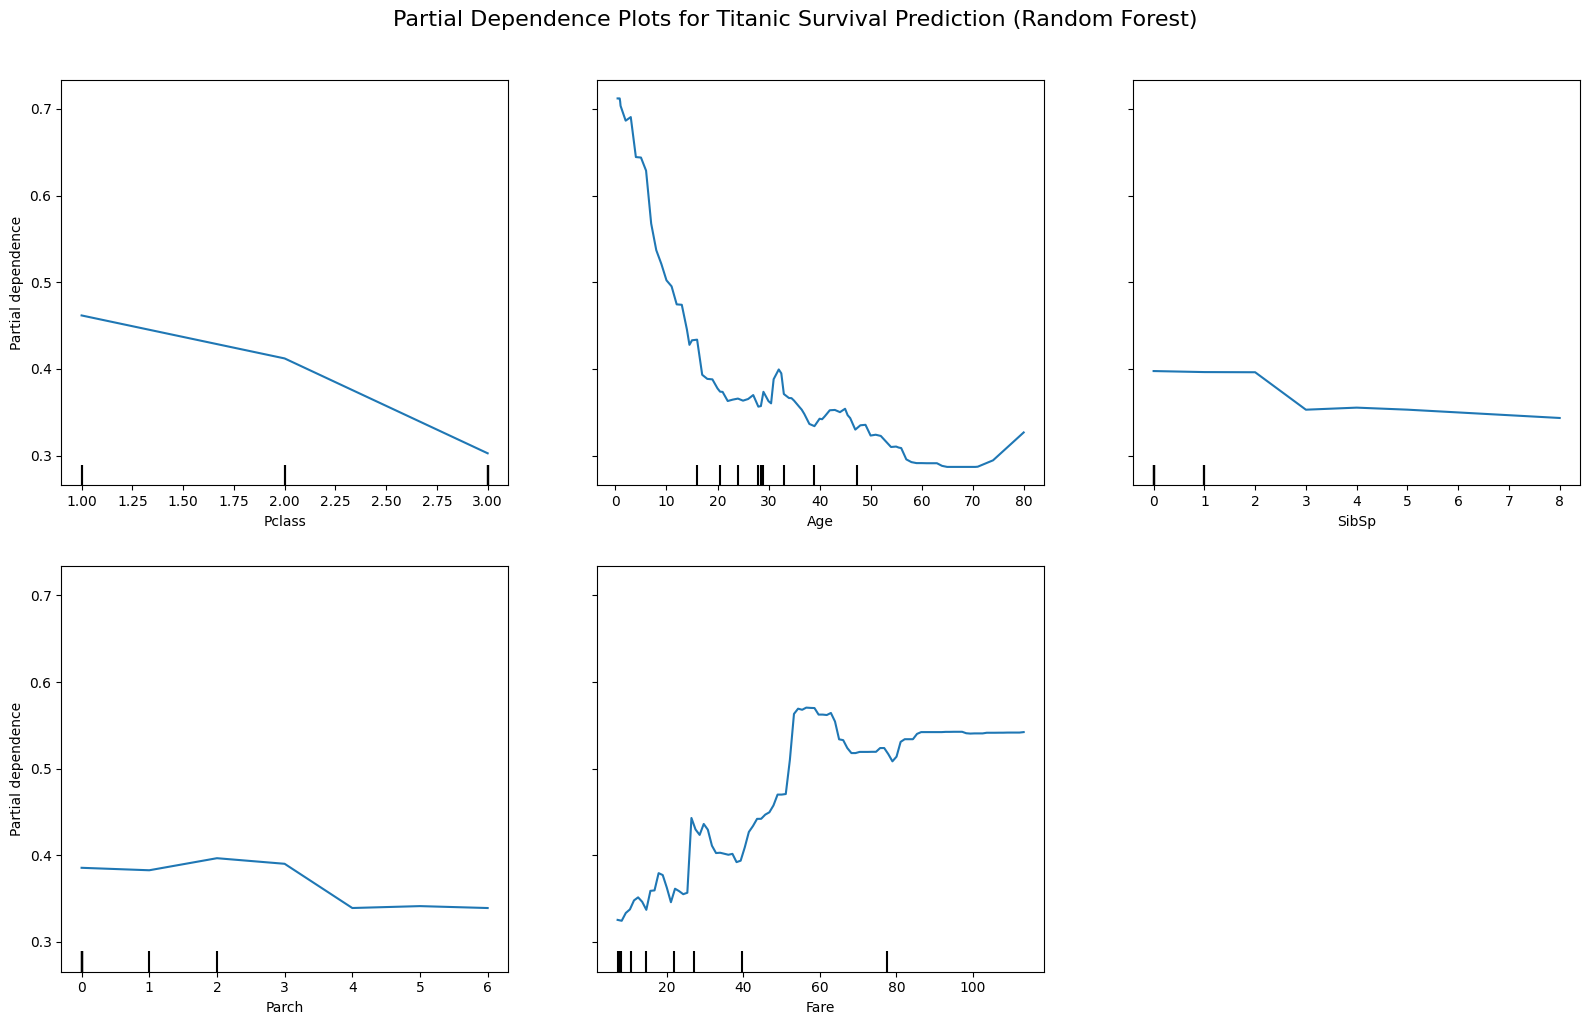

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Transform X_train using the preprocessor to get the actual feature matrix
X_train_transformed = random_forest_model.named_steps['preprocessor'].transform(X_train)

# Convert sparse matrix to dense array if needed
if hasattr(X_train_transformed, 'toarray'):
    X_train_transformed = X_train_transformed.toarray()

# Get feature names after preprocessing
numerical_feature_names = numerical_features  # ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_feature_names = ['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
all_feature_names = numerical_feature_names + categorical_feature_names

# Create figure and axes
fig, ax = plt.subplots(figsize=(16, 10))

# Select ONLY numerical features to avoid binary feature issues
# 0=Pclass, 1=Age, 2=SibSp, 3=Parch, 4=Fare
features_to_plot = [0, 1, 2, 3, 4]

# Create PDP using the classifier directly (not the pipeline)
PartialDependenceDisplay.from_estimator(
    random_forest_model.named_steps['classifier'],
    X_train_transformed,
    features=features_to_plot,
    feature_names=all_feature_names,
    ax=ax,
    n_cols=3
)

plt.suptitle('Partial Dependence Plots for Titanic Survival Prediction (Random Forest)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate average predicted survival probability by Sex
sex_survival = titanic_df.groupby('Sex')['Survived'].apply(
    lambda x: (x == 'Survived').sum() / len(x) * 100
).reset_index()
sex_survival.columns = ['Sex', 'Survival Rate (%)']

fig = px.bar(
    sex_survival,
    x='Sex',
    y='Survival Rate (%)',
    title='Actual Survival Rate by Sex',
    color='Sex',
    color_discrete_map={'male': '#1f77b4', 'female': '#ff7f0e'},
    text='Survival Rate (%)'
)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(showlegend=False, yaxis_range=[0, 100])
fig.show()

PDPs are great for numerical data. Since Sex was turned into categorical data after the proprocessing (Sex_male and Sex_female), they are not included in this PDP. Embarked is also not on here for similar reasons.

We can see that Age, Fare, and even Pclass mattered the most when determing your chances of survival.

The younger you were, the more your ticket cost, and the higher in class you were made it more likely you would survive on that fateful day, especially if you're a female.

In [ ]:
print("Rate of Survival by Category:")

# Category / Total in Category:

print("Survival Rate by Sex:")
femaleSurvivedRate = (233 / 314) * 100                            # female survivors / total female
maleSurvivedRate = (109 / 577) * 100                              # male survivors / total male
print(f"Female Survival Rate: {femaleSurvivedRate:0.2f}%")
print(f"Male Survival Rate: {maleSurvivedRate:0.2f}%")
print("\n")

print("Survival Rate by Class:")
firstSurvivedRate = (136 / 216) * 100                             # first class passenger survivors / total first class
secondSurvivedRate = (87 / 184) * 100                             # second class passenger survivors / total second class
thirdSurvivedRate = (119 / 419) * 100                             # third class passenger survivors / total third class
print(f"First Class Survival Rate: {firstSurvivedRate:0.2f}%")
print(f"Second Class Survival Rate: {secondSurvivedRate:0.2f}%")
print(f"Third Class Survival Rate: {thirdSurvivedRate:0.2f}%")
print("\n")

print("Survival Rate by Age:")
childSurvivedRate = (40 / 69) * 100                                # child passenger survivors / total children
youthSurvivedRate = (47 / 135) * 100                               # youth passenger survivors / total youth
youngAdultSurvivedRate = (120 / 293) * 100                         # young adult passenger survivors / total young adults
middleAgeSurvivedRate = (71 / 177) * 100                           # middle age passenger survivors / total middle age adults
elderlySurvivedRate = (12 / 40) * 100                              # elderly passenger survivors / total elderly
print(f"Child Survival Rate: {childSurvivedRate:0.2f}%")
print(f"Youth Survival Rate: {youthSurvivedRate:0.2f}%")
print(f"Young Adult Survival Rate: {youngAdultSurvivedRate:0.2f}%")
print(f"Middle Age Survival Rate: {middleAgeSurvivedRate:0.2f}%")
print(f"Elderly Survival Rate: {elderlySurvivedRate:0.2f}%")


Rate of Survival by Category:
Survival Rate by Sex:
Female Survival Rate: 74.20%
Male Survival Rate: 18.89%


Survival Rate by Class:
First Class Survival Rate: 62.96%
Second Class Survival Rate: 47.28%
Third Class Survival Rate: 28.40%


Survival Rate by Age:
Child Survival Rate: 57.97%
Youth Survival Rate: 34.81%
Young Adult Survival Rate: 40.96%
Middle Age Survival Rate: 40.11%
Elderly Survival Rate: 30.00%


## Findings


Based on our Exploratory Data Analysis, we can see that the sex of the passenger, the passenger’s class, and their age was a factor in whether someone survived or not.

We first looked at the sex of all the passengers. Out of all the women in our dataset, about **74.20%** survived compared to about **18.89%** of all the men in our dataset. From this, we can see that the sex of a passenger was a factor in whether someone survived or not with women being far more likely to survive than men.

Next, we looked at the class of all the passengers. Looking at each of the classes separately, about **62.96%** of First Class passengers survived, about **47.28%** of Second Class passengers survived, and about **28.40%** of Third Class passengers survived. For class to not be a factor, the rates between each class should be relatively similar, however this isn’t the case. This indicates that class was a factor in whether or not someone survived with First Class passengers being more likely to survive than anyone other class.

Last, we looked at the age of the passengers. We split the dataset into five (5) age groups: Child (0-11), Youth (12-20), Young Adult (21-35), Middle Age (36-55), and Elderly (56+). These age ranges were based on the time period’s view on age and the life expectancy in 1912. We considered anyone under 21 to be a child/youth since that seems to be the age of majority in 1912. For each age group’s survival rate, **57.97%** of Children ages 0-11 survived, **37.81%** of Youths survived, **40.96%** of Young Adults survived, **40.11%** of Middle-Aged Adults survived, and **30.00%** of Elderly Adults survived. From here, we see that the likelihood of survival based on age is only significant if the passenger is under 12 years old.

If we were to split the dataset into just children and adults (meaning those under 21 and anyone 21 and older), **45.56%** of children survived while **36.57%** of adults survived. These two percentages are relatively similar indicating that children were slightly more likely to survive than adults.

In terms of our question about who was most likely to survive and if “women and children” were prioritized, we can see that it was correct. Women were more likely to survive, which indicates that they were most likely prioritized. This dataset also indicates that only young children ages 0-11 were prioritized. We also found that class was a factor in survival and that the first class passengers were more likely to survive than others. These also factored into our predictions. With being a woman, being under 12 years old, and/or in first class being the three factors with a higher survival rate, our model tended to predict someone to die more than it was to predict someone to survive.

The real world implications of this dataset show that in life-or-death situations, humanity tends to prioritize children over anyone else, indicating a willingness to help the most vulnerable. People will also try to save women over anyone else which points to cultural views on gender. Unfortunately, this dataset also shows that First Class passengers were prioritized as well, which indicates selfishness and a general disregard for the poor.